In [14]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

# Preprocessing

In [15]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [16]:
train.shape

(165034, 11)

In [17]:
X = train.drop(columns='Exited')
y = train.Exited

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.15)

In [19]:
prepro = Preprocessing()

In [20]:
X_train_scld = prepro.fit_transform(X_train)
X_test_scld = prepro.transform(X_test)

In [21]:
X_train_balanced, y_train_balanced = resample(X_train_scld[y_train == 1], y_train[y_train == 1], n_samples=np.sum(y_train == 0), replace=True, random_state=42)

In [22]:
X_train_balanced = np.concatenate((X_train_scld[y_train == 0], X_train_balanced))
y_train_balanced = np.concatenate((y_train[y_train == 0], y_train_balanced))

# Fit

In [11]:
params = {
    'hidden_layer_sizes':(100,),
    'max_iter':500,
    'activation':'relu',
    'learning_rate':'constant',
    'learning_rate_init':0.0001
    
}

nn = MLPClassifier(
    **params, random_state=42)

In [12]:
nn.fit(X_train_balanced, y_train_balanced)

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(learning_rate_init=0.0001, max_iter=500, random_state=42)

In [ ]:
pred = nn.predict(X_test_scld)
pred_proba = nn.predict_proba(X_test_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
RocScore  = roc_auc_score(y_test, pred_proba)
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.890367


In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     19518
           1       0.54      0.80      0.64      5238

    accuracy                           0.81     24756
   macro avg       0.74      0.81      0.76     24756
weighted avg       0.85      0.81      0.82     24756



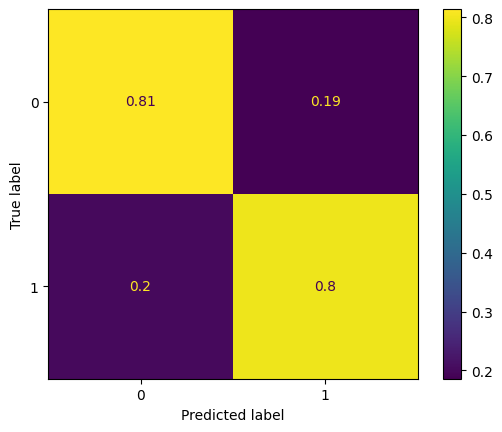

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred, normalize='true')).plot()

# Grid Search CV

In [27]:
params = {
    'hidden_layer_sizes':[(100,),(100,50),(100,50,25)],
    'max_iter':[500],
    'activation':['relu'],
    'learning_rate':['constant', 'invscaling', 'adaptive'],
    'learning_rate_init':[0.01,0.001,0.0001],
    'alpha':[0.01,0.001,0.0001]
}

grid = GridSearchCV(
    MLPClassifier(),
    param_grid=params,
    scoring='roc_auc', 
    verbose=20,
    cv=4,
    n_jobs=-1
    )

In [28]:
grid.fit(X_train_balanced, y_train_balanced)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV 1/4; 1/81] START activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500
[CV 2/4; 1/81] START activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500
[CV 3/4; 1/81] START activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500
[CV 4/4; 1/81] START activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500
[CV 1/4; 2/81] START activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, max_iter=500
[CV 2/4; 2/81] START activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, max_iter=500
[CV 3/4; 2/81] START activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, l

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4; 21/81] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=500;, score=0.896 total time= 7.5min
[CV 1/4; 28/81] START activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500
[CV 3/4; 24/81] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0001, max_iter=500;, score=0.893 total time= 3.9min
[CV 2/4; 28/81] START activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500
[CV 1/4; 28/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500;, score=0.890 total time=  11.6s
[CV 3/4; 28/81] START activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500
[CV 3/4; 28/81] END activation=relu, alpha=

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4; 48/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=500;, score=0.895 total time= 7.4min
[CV 3/4; 54/81] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=500
[CV 3/4; 52/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.01, max_iter=500;, score=0.893 total time= 1.2min
[CV 4/4; 54/81] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=500
[CV 2/4; 51/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0001, max_iter=500;, score=0.895 total time= 5.6min
[CV 1/4; 55/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, max_iter=500
[CV 1/4; 55/81]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4; 51/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0001, max_iter=500;, score=0.896 total time= 7.7min
[CV 1/4; 57/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.0001, max_iter=500
[CV 2/4; 53/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500;, score=0.905 total time= 4.9min
[CV 2/4; 57/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.0001, max_iter=500
[CV 3/4; 56/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, max_iter=500;, score=0.890 total time=  37.4s
[CV 3/4; 57/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.0001, max_iter=500
[CV 2/4; 57/81] END activation=

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4; 51/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0001, max_iter=500;, score=0.896 total time= 7.6min
[CV 2/4; 59/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, learning_rate_init=0.001, max_iter=500
[CV 3/4; 53/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500;, score=0.904 total time= 5.6min
[CV 3/4; 59/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, learning_rate_init=0.001, max_iter=500
[CV 1/4; 53/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500;, score=0.904 total time= 6.0min
[CV 4/4; 59/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, learning_rate_init=0.001, max_iter=500
[CV 4/4; 53/81] END ac

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4; 54/81] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=500;, score=0.896 total time= 7.5min
[CV 1/4; 67/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=invscaling, learning_rate_init=0.01, max_iter=500
[CV 2/4; 64/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, max_iter=500;, score=0.897 total time= 1.3min
[CV 2/4; 67/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=invscaling, learning_rate_init=0.01, max_iter=500
[CV 4/4; 64/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, max_iter=500;, score=0.896 total time= 1.5min
[CV 3/4; 67/81] START activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=invscaling, learning_rate_init=0.01, max_iter=500
[CV 3/4; 64/81] END activa

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4; 78/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0001, max_iter=500;, score=0.896 total time= 6.9min
[CV 4/4; 78/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0001, max_iter=500;, score=0.897 total time= 6.2min


/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4; 78/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0001, max_iter=500;, score=0.895 total time= 6.8min
[CV 1/4; 81/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=500;, score=0.896 total time= 3.6min
[CV 3/4; 80/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500;, score=0.902 total time= 3.8min
[CV 4/4; 80/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500;, score=0.906 total time= 3.9min
[CV 2/4; 80/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500;, score=0.907 total time= 4.6min


/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4; 80/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500;, score=0.907 total time= 5.6min
[CV 2/4; 81/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=500;, score=0.895 total time= 4.1min
[CV 4/4; 81/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=500;, score=0.894 total time= 3.1min
[CV 3/4; 81/81] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=500;, score=0.894 total time= 3.7min


GridSearchCV(cv=4, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.01, 0.001, 0.0001],
                         'hidden_layer_sizes': [(100,), (100, 50),
                                                (100, 50, 25)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'learning_rate_init': [0.01, 0.001, 0.0001],
                         'max_iter': [500]},
             scoring='roc_auc', verbose=20)

In [29]:
grid.score(X_test_scld,y_test)

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


0.8549679237942939

In [30]:
grid.best_estimator_

MLPClassifier(hidden_layer_sizes=(100, 50, 25), learning_rate='adaptive',
              max_iter=500)

# Submission

In [ ]:
X_val_scld = prepro.transform(test)

In [ ]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [ ]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
submission

,Exited
id,
165034,0.085936
165035,0.947197
165036,0.079534
165037,0.519489
165038,0.638603
...,...
275052,0.132850
275053,0.217605
275054,0.071276


In [ ]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [ ]:
submission.to_csv(f"submission/{name}.csv")